In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from HMC_Tools import EvaluateHMC
from BFGS_Tools import *

In [5]:
class bfgs_hmc:
    def __init__(self, q0):
        self.q0 = q0

        self.Nq = len(q0)
        self.massinv = np.eye(self.Nq)
        self.MAX_SAMPLES = 10000


    def logp(self, x):
        return -0.5 * np.sum(x**2)

    def grad(self, x):
        return -x
    
    def f(self,x):
        return self.logp(x), self.grad(x)

    def create_p(self):
        p = np.random.normal(loc=0, scale=1.0, size=self.Nq) 
        return p
    
    def Kp(self, p, P, Q, B1):
        return 0.5 * np.dot(p, self.Hz_product(P, Q, B1, p.T)) 


    def set_memmory(self, K):
        sample_mem = np.random.rand(K, self.Nq)
        x_mem = sample_mem[1:, :]  # x_{2:k}, //matrix//  K-1 x Nq dims
        grad_mem = np.zeros((K-1, self.Nq))  # gradient, //matrix//  K-1 x Nq dims
        U_mem = np.zeros(K-1)  # potential energy, //vector// K-1 dims

        # save potential energy and gradient for previous 2:K samples
        for i in range(K-1):
            logp, grad = self.f(x_mem[i, :])
            U_mem[i] = -logp
            grad_mem[i,:] = -grad

        q0  = sample_mem[0, :]  # x_1^(t)
        logp0, grad0 = self.f(q0)

        return q0, logp0, grad0, x_mem, U_mem, grad_mem


    def leapfrog_BFGS(self, q, p, L, e, P, Q, B1):
        #L_rand = int(np.ceil(np.random.rand() * L))
        #eps = (0.9 + np.random.rand() / 5) * e
        L_rand = L
        eps = e

        X_path = np.zeros((L_rand+1, self.Nq))
        E_path = np.zeros(L_rand+1)
        K_path = np.zeros(L_rand+1)
        X_path[0, :] = q
        E_path[0], grad = self.f(q)
        g0 = -grad
        E_path[0] = -E_path[0]
        K_path[0] = 0.5 * np.dot(p, Hz_product(P, Q, B1, p.T))  # Kp = 0.5 * p^T * M^-1 * P

        for i in range(1, L_rand+1):
            p = p + 1/2 * eps * grad
            q = q + eps * Hz_product(P, Q, B1, p.T).T  #massinv @ p
            E_new, grad = self.f(q)
            p = p + 1/2 * eps * grad

            X_path[i, :] = q
            E_path[i] = -E_new 
            K_path[i] = 0.5 * np.dot(p, Hz_product(P, Q, B1, p.T))

        g = -grad
        return X_path, E_path, K_path, g0, g
    

    def sampling(self, Msamples, Madapt, K, L, epsilon, gamma, debug=False):
    
        acprate = 0
        samples = []
        lnprob_list = []

        B1 = np.eye(self.Nq) * gamma # Initialize the starting Hessian matrix (mass matrix)

        ### Initalize memory excluding the first sample in the memory ###
        sample, logp, grad, x_mem, U_mem, grad_mem = self.set_memmory(K) #sample is x_1^(t)

    
        ### Start HMC sampling ....... ###
        for m in range(1, self.MAX_SAMPLES):
            if len(samples) >= Msamples + Madapt+1:
                break
            if np.mod(m,500) == 0:
                print('sampling iteration {}'.format(m))

            # precompute BFGS-conjugate matrices
            P, Q, U, T = update_PQUT(x_mem, grad_mem, U_mem, B1)

            # randomly draw momentum from B
            p = self.create_p()  
            p = Cz_product(U, T, B1, p.T)  
            p = p.T

            # simulate trajectory
            X_path, E_path, K_path, g0, g = self.leapfrog_BFGS(sample, p, L, epsilon, P, Q, B1)

            if debug:
                plt.figure(1)
                plt.plot(X_path[:, 0], X_path[:, -1], '.-')
                plt.xlabel('x1')
                plt.ylabel('x2')
                plt.figure(2)
                plt.clf()
                plt.plot(E_path, 'blue')
                plt.plot(K_path, 'red')
                plt.plot(E_path + K_path,'--')
                plt.grid()
                plt.pause(0.1)

            # accept or reject?
            H_current = E_path[0] + K_path[0]
            H_proposed = E_path[-1] + K_path[-1]

            denergy = H_current - H_proposed
            acceptance_prob = min(0, denergy)
            alpha = np.log(np.random.rand())

              
            sample_next = x_mem[0, :]
            if alpha < acceptance_prob:
                # !!!Accept
                sample = X_path[-1,:]
                # update memory
                x_mem = np.vstack((x_mem[1:, :], sample))
                grad_mem = np.vstack((grad_mem[1:, :], g))
                U_mem = np.hstack((U_mem[1:], E_path[-1]))

                acprate += 1
                samples.append(sample)
                lnprob_list.append(-E_path[-1])
               
            else:
                # update memory
                x_mem = np.vstack((x_mem[1:, :], sample))     #raw code
                grad_mem = np.vstack((grad_mem[1:, :], g0))
                U_mem = np.hstack((U_mem[1:], E_path[0]))

                '''
                # update memory
                x_mem = np.vstack((x_mem[1:, :], x_mem[-1, :]))     # from paper
                grad_mem = np.vstack((grad_mem[1:, :], grad_mem[-1, :]))
                U_mem = np.hstack((U_mem[1:], U_mem[-1]))
                '''

            sample = sample_next
    
        samples = np.array(samples)
        print('Acceptance_rate = {}'.format(acprate/Msamples))
        return samples,lnprob_list



In [6]:
Nq = 2
q0 = np.random.normal(0, 1, Nq)

Msamples = 5000
Madapt = 1000
K=10
L = 50
epsilon = 0.5
gamma = 0.1
debug=False


print("==============Start Sampling=============")
t_start = time.time()
hmc = bfgs_hmc(q0)
samples, lnprob = hmc.sampling(Msamples, Madapt, K, L, epsilon, gamma)
t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))
time_cost = t_stop - t_start

==============Start Sampling=============
sampling iteration 500
sampling iteration 1000
sampling iteration 1500
sampling iteration 2000
sampling iteration 2500
sampling iteration 3000
sampling iteration 3500
sampling iteration 4000
sampling iteration 4500
sampling iteration 5000


<Figure size 1000x1000 with 0 Axes>

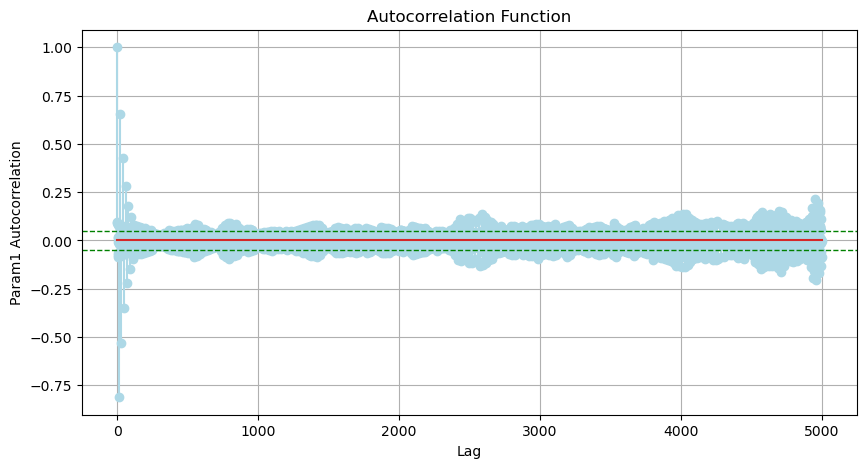

Effective Sample Size (ESS): 80.13577015081256
Time per Effective Sample Size (ESS):0.36113557003033553 second


In [ ]:
max_lag=5000
data = samples[:,1]

hmc_tool = EvaluateHMC(data)
ESS = hmc_tool.effective_sample_size(max_lag)
hmc_tool.plot_autocorrelation(max_lag, label='Param1')
print("Effective Sample Size (ESS):", ESS)


TES = time_cost/ESS
print("Time per Effective Sample Size (ESS):{} second".format(TES))

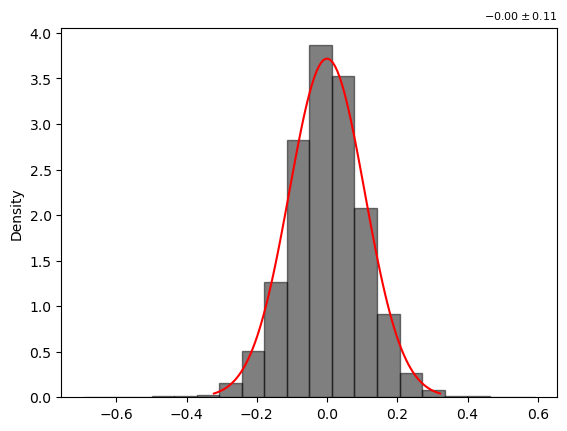

In [ ]:
from scipy.stats import norm
mu, sigma = np.mean(data), np.std(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
gaussian = norm.pdf(x, mu, sigma)
plt.plot(x, gaussian, color='red', label='Gaussian Distribution')
plt.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True)
plt.title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
plt.ylabel('Density')
plt.show()
